# Метод опорных векторов - Support Vector Machines 

## Подделка вина

Чаще всего вино подделывают, разбавляя его более дешёвыми продуктами (например, соком), а иногда и с помощью опасных химикатов или подсластителей (чтобы добавить цвет или вкус).

Другой тип подделки - продажа более дешёвых вин под более дорогими марками.

## Цели проекта

Необходимо создать модель машинного обучения, которая предскажет низкое качество вина (то есть, "подделку"). Нужно узнать, возможно ли определить разницу между дешёвыми и дорогими винами.


Источник данных: *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

---
---

**Обшая цель - используя данные о винах, разработать модель машинного обучения, которая будет предсказывать на основе некоторых химических тестов, является ли вино настоящим или поддельным.**

---
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./wine_fraud.csv")

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


**Возможные начения в целевой колонке quality**

In [273]:
df['quality'].unique()

array(['Legit', 'Fraud'], dtype=object)

**Количество записей для каждой из категорий - Legit и Fraud**

<AxesSubplot:xlabel='quality', ylabel='count'>

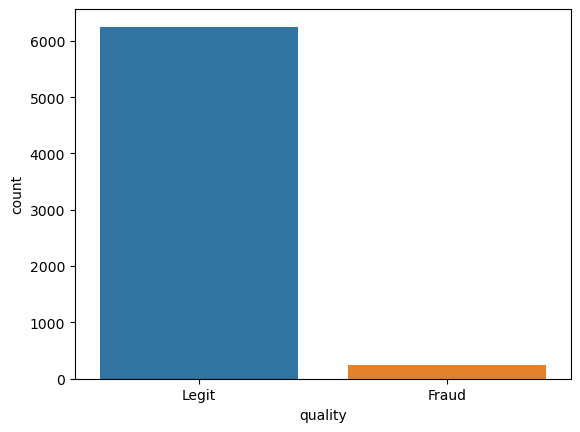

In [274]:
sns.countplot(data=df, x='quality')

**Ввыясним, есть ли разница в количестве подделок в зависимости от того, красное вино или белое.**

<AxesSubplot:xlabel='type', ylabel='count'>

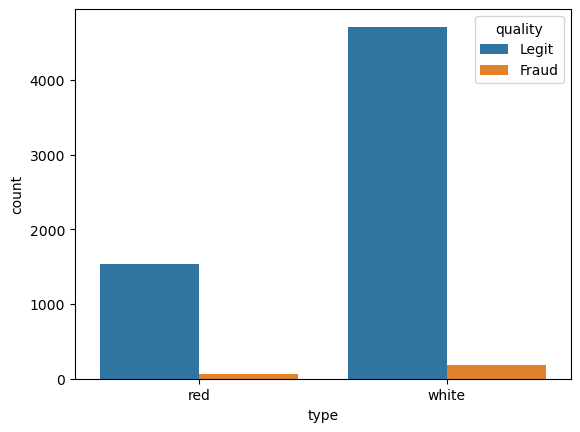

In [275]:
sns.countplot(data=df, x='type', hue='quality')

**Процент белых и красных вин, являющихся подделкой**

In [276]:
red_wines = df[(df['type'] == 'red')]
white_wines = df[(df['type'] == 'white')]

In [277]:
perc_of_fraud_red = len(red_wines[red_wines['quality']=='Fraud']) / len(red_wines) * 100
print('Percentage of fraud in Red Wines:', perc_of_fraud_red, sep='\n')

Percentage of fraud in Red Wines:
3.9399624765478425


In [278]:
perc_of_fraud_white = len(white_wines[white_wines['quality']=='Fraud']) / len(white_wines) * 100
print('Percentage of fraud in White Wines:', perc_of_fraud_white, sep='\n')

Percentage of fraud in White Wines:
3.7362188648427925


**Корреляции между различными признаками и колонкой "quality"**

In [279]:
df['Fraud'] = df['quality'].map({'Legit':0,'Fraud':1})
corrs_with_fraud = df.corr()['Fraud']
corrs_with_fraud

fixed acidity           0.021794
volatile acidity        0.151228
citric acid            -0.061789
residual sugar         -0.048756
chlorides               0.034499
free sulfur dioxide    -0.085204
total sulfur dioxide   -0.035252
density                 0.016351
pH                      0.020107
sulphates              -0.034046
alcohol                -0.051141
Fraud                   1.000000
Name: Fraud, dtype: float64

**ЗАДАНИЕ: Нарисуйте график bar plot, отобразив значения корреляции для поддельных вин.**

In [280]:
corrs_with_fraud = corrs_with_fraud.drop('Fraud').sort_values()

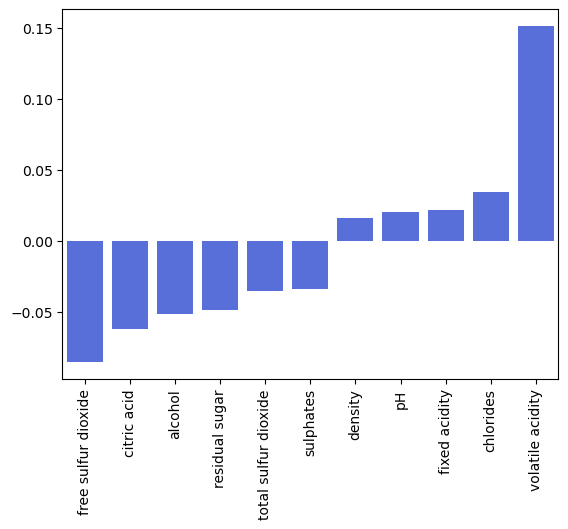

In [281]:
sns.barplot(x=corrs_with_fraud.index, 
            y=corrs_with_fraud.values, 
            color='#4361ee')
plt.xticks(rotation=90)
plt.show()

**Связи между переменными**

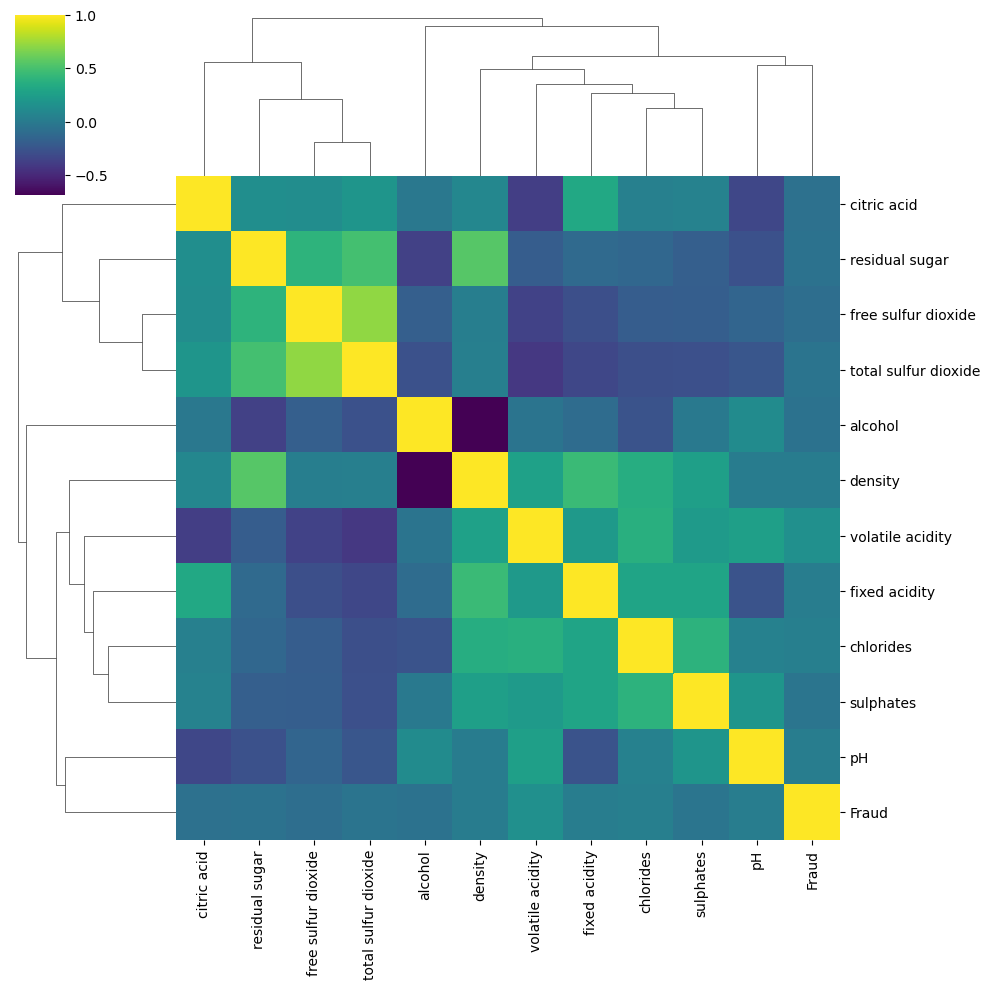

In [282]:
sns.clustermap(data=df.corr(), cmap='viridis')

----
## Модель машинного обучения

**Конвертация колонки "type" из текстовых значений "red" и "white" в dummy-переменные:**

In [283]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df = df.drop('Fraud', axis=1)

**Разделение данных на признаки X и целевую переменную y (колонка "quality")**

In [284]:
X = df.drop('quality', axis=1)

In [285]:
y = df['quality']

**Разбиение данных на обучающий и тестовый набор данных, в отношении 90% и 10%**

In [249]:
from sklearn.model_selection import train_test_split

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)


**Масштабирование признаков**

In [287]:
from sklearn.preprocessing import StandardScaler

In [288]:
scaler = StandardScaler()

In [289]:
scaled_X_train = scaler.fit_transform(X_train)

In [290]:
scaled_X_test = scaler.transform(X_test)

**Экземпляр классификатора Support Vector Machine. Поскольку мы знаем, что классы несбалансированы, для решения этой проблемы мы можем автоматически подобрать веса обратно пропорционально тому, как часто встречаются классы во входных переменных с помощью параметра class_weight**

In [291]:
from sklearn.svm import SVC


In [292]:
svc = SVC(class_weight='balanced')

**Поиск по сетке значений параметров C и gamma.**

In [293]:
from sklearn.model_selection import GridSearchCV

In [294]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto']
}

In [295]:
grid_model = GridSearchCV(svc, param_grid)

In [296]:
grid_model.fit(scaled_X_train, y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto']})

In [297]:
grid_model.best_params_

{'C': 1, 'gamma': 'auto'}

**Оценка модели**

In [298]:
from sklearn.metrics import confusion_matrix, classification_report

In [299]:
y_pred = grid_model.predict(scaled_X_test)

In [300]:
confusion_matrix(y_test, y_pred)

array([[ 17,  10],
       [ 92, 531]])

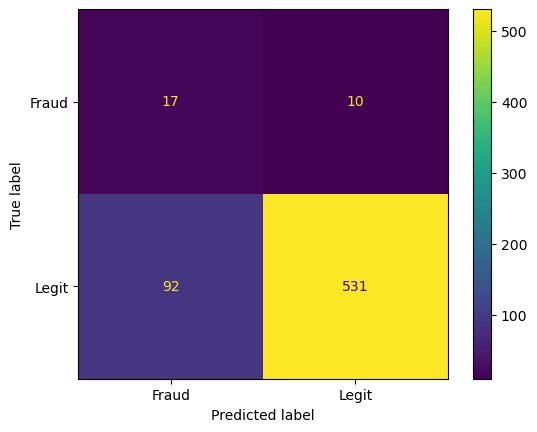

In [303]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(grid_model, scaled_X_test, y_test)

In [301]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Fraud       0.16      0.63      0.25        27
       Legit       0.98      0.85      0.91       623

    accuracy                           0.84       650
   macro avg       0.57      0.74      0.58       650
weighted avg       0.95      0.84      0.88       650



**Вывод: результаты модели не соответствуют желанному результату. Модель не смогла достаточно хорошо предсказать поддельные вина. Причина в том, что данных для анализа недостаточно. Для этой задачи следует найти больше информации**